# 1. Import Libraries & Load Data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.model_selection import train_test_split

# set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# Load the dataset
df = pd.read_csv("../data/Hs.csv")

print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.head()

Dataset shape: (68754, 13)
Number of rows: 68754
Number of columns: 13


,Xp,Yp,Hsig,Dir,Depth,X-Windv,Y-Windv,U10,Season,Temperature,Wind_Speed,Wave_Steepness,Wind_Dir_Category
0,52.57,27.38,0.03444,353.248,35.6057,0.3128,-1.7557,1.06,Summer,14.045279,1.783347,0.023272,West
1,52.57,27.38,0.03459,350.817,35.6057,0.4156,-1.0176,0.40,Summer,13.727790,1.099197,0.022787,West
2,52.57,27.38,0.03479,354.399,35.6057,0.4148,-1.7209,1.26,Summer,14.120766,1.770185,0.025072,West
3,52.57,27.38,0.03502,348.335,35.6057,0.1343,-0.3577,1.39,Fall,14.558437,0.382081,0.022834,West
4,52.57,27.38,0.03545,138.355,35.6057,1.9610,-0.3797,1.06,Summer,13.679845,1.997422,0.016984,East


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68754 entries, 0 to 68753
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Xp                 68754 non-null  float64
 1   Yp                 68754 non-null  float64
 2   Hsig               68754 non-null  float64
 3   Dir                68754 non-null  float64
 4   Depth              68754 non-null  float64
 5   X-Windv            68754 non-null  float64
 6   Y-Windv            68738 non-null  float64
 7   U10                528 non-null    float64
 8   Season             68746 non-null  object 
 9   Temperature        68746 non-null  float64
 10  Wind_Speed         68738 non-null  float64
 11  Wave_Steepness     68746 non-null  float64
 12  Wind_Dir_Category  68746 non-null  object 
dtypes: float64(11), object(2)
memory usage: 6.8+ MB


In [4]:
# Drop duplicate rows
df = df.drop_duplicates()
print(f"Dataset shape after dropping duplicates: {df.shape}")

Dataset shape after dropping duplicates: (68751, 13)


# 2. Train-Test Split (70%-30%)

In [5]:
# Separate features and target variable
X = df.drop(columns=["Hsig"])
y = df["Hsig"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (48125, 12)
Testing set shape: (20626, 12)


# 3. Exploratory Data Analysis (EDA)
On training data only

## 3.1 Missing Values and Constant Values

In [6]:
# Combine X_train and y_train temporarily for EDA purposes
train_eda = pd.concat([X_train, y_train], axis=1)

# Calculate percentage of missing values per column to inform imputation strategies
missing_train_eda = pd.DataFrame({
    "missing_count": train_eda.isnull().sum(),
    "missing_percentage": train_eda.isnull().mean() * 100,
    "dataType": train_eda.dtypes
})

# Sort the missing df
missing_train_eda = missing_train_eda[missing_train_eda["missing_count"] > 0].sort_values(by="missing_percentage", ascending=False)

print("Missing values summary in training set:")
print(missing_train_eda)

Missing values summary in training set:
                   missing_count  missing_percentage dataType
U10                        47758           99.237403  float64
Y-Windv                       14            0.029091  float64
Wind_Speed                    12            0.024935  float64
Wave_Steepness                 8            0.016623  float64
Season                         6            0.012468   object
Temperature                    6            0.012468  float64
Wind_Dir_Category              6            0.012468   object


- Over 99% records are missing for the `U10` feature, consider dropping it.
- Imputation can be used for the rest of the columns (mean / median).

In [7]:
# Take note of columns to drop
cols_to_drop = ['U10']

In [8]:
# Identify constant values
for col in train_eda.select_dtypes(include=['float64']).columns:
    unique_values = train_eda[col].nunique()
    print(f"Column '{col}' has {unique_values} unique values.")

Column 'Xp' has 1 unique values.
Column 'Yp' has 1 unique values.
Column 'Dir' has 33784 unique values.
Column 'Depth' has 1 unique values.
Column 'X-Windv' has 38328 unique values.
Column 'Y-Windv' has 37954 unique values.
Column 'U10' has 115 unique values.
Column 'Temperature' has 48114 unique values.
Column 'Wind_Speed' has 47820 unique values.
Column 'Wave_Steepness' has 47858 unique values.
Column 'Hsig' has 36001 unique values.


In [9]:
# Column 'Xp', 'Yp', 'Depth' have constant values, consider dropping it.
cols_to_drop += ['Xp', 'Yp', 'Depth']
cols_to_drop

['U10', 'Xp', 'Yp', 'Depth']

## 3.2 Distributions

In [10]:
numeric_cols = train_eda.drop(columns=cols_to_drop).select_dtypes(include=['float64']).columns.tolist()
cat_cols = train_eda.drop(columns=cols_to_drop).select_dtypes(include=['object']).columns.tolist()
print(f"Numerical features: {numeric_cols}")
print(f"Categorical features: {cat_cols}")

Numerical features: ['Dir', 'X-Windv', 'Y-Windv', 'Temperature', 'Wind_Speed', 'Wave_Steepness', 'Hsig']
Categorical features: ['Season', 'Wind_Dir_Category']


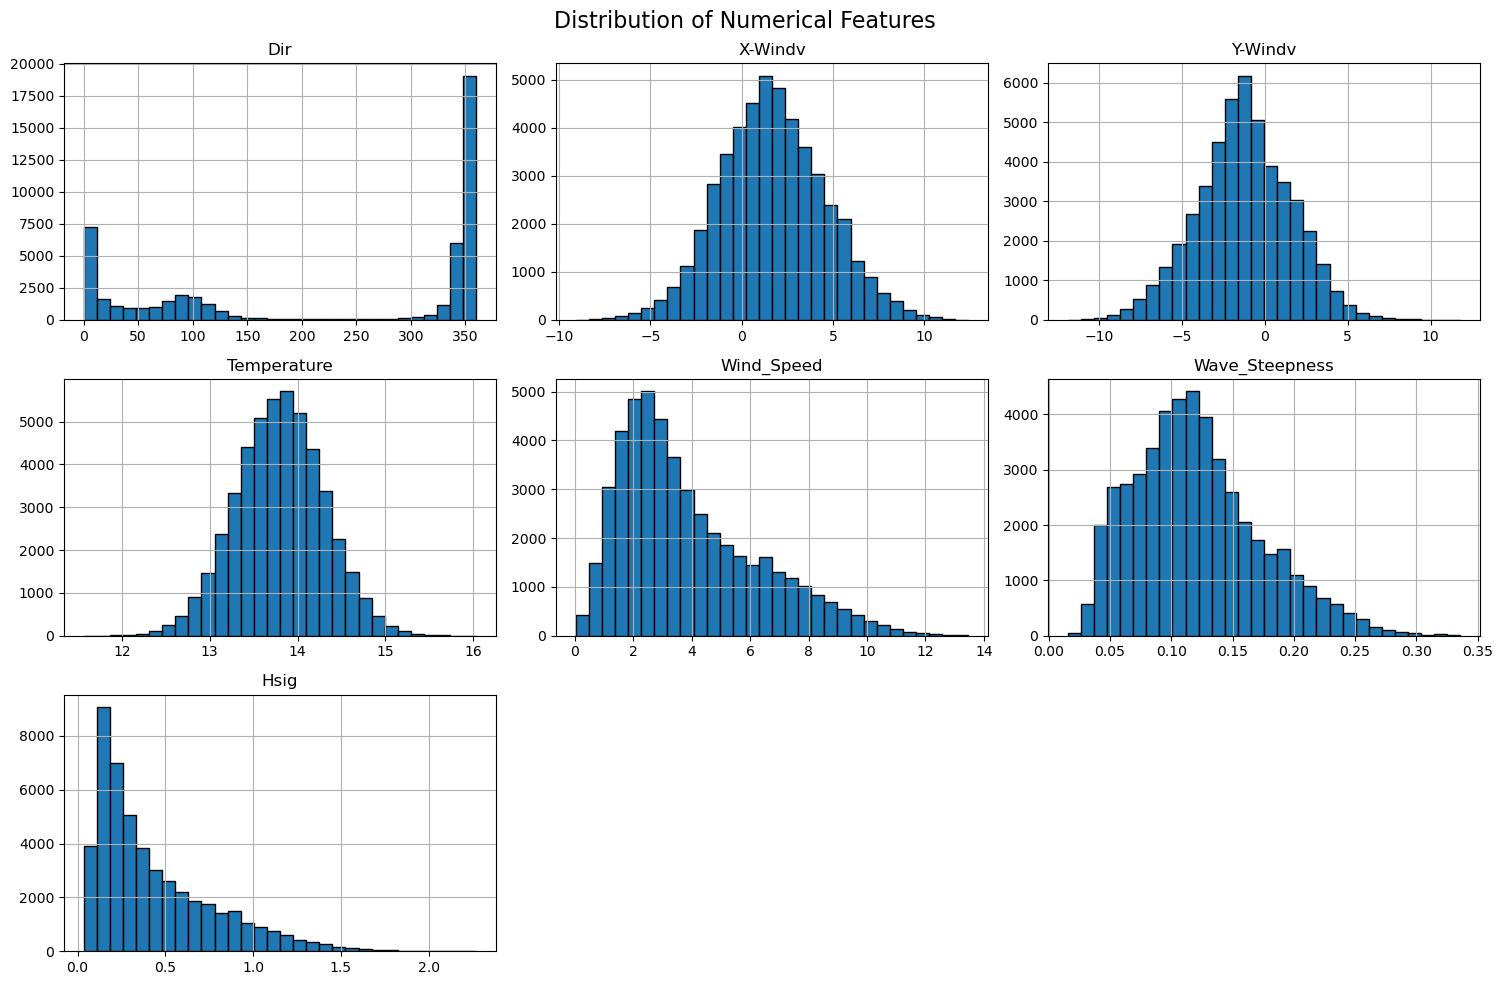

In [11]:
# Distribution of the numerical features
train_eda[numeric_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

**Features**:  
- 'Dir': continuous but cyclic (0=360), consider cyclic encoding to sin and cos.
- 'X-Windv', 'Y-Windv', 'Temperature' is normally distributed, consider StandardScaler.
- 'Wind_Speed', 'Wind_Steepness' is right-skewed, consider using Log Transformation before scaling.

**Target Variable**
- 'Hsig' is also right-skewed, baseline model (Linear Regression) might struggle to predict, Tree-based ensembles models can handle this well.

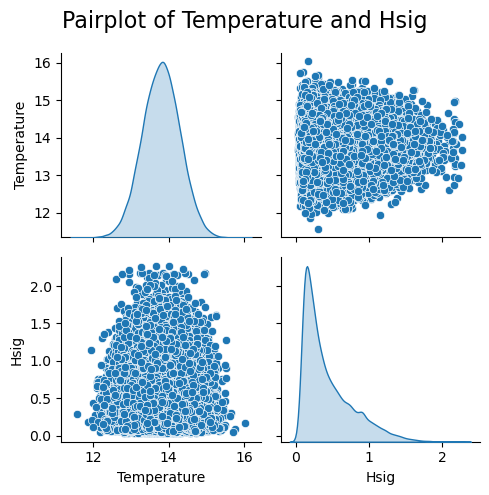

In [12]:
# Pairplot of Temperature and Hsig, indicating binning opportunities
sns.pairplot(train_eda, vars=['Temperature', 'Hsig'], diag_kind='kde')
plt.suptitle("Pairplot of Temperature and Hsig", fontsize=16)
plt.tight_layout()
plt.show()

- Spot non-linear relationship between 'Temperature' and 'Hsig';
- Extreme wave height only occur at moderate temperature (13.5-14.5)
- `KBinsDiscretizer` can be used to perform binning numerical 'Temperature' value to Low, Moderate, High bins.

## 3.3 Correlation & Collinearity Analysis

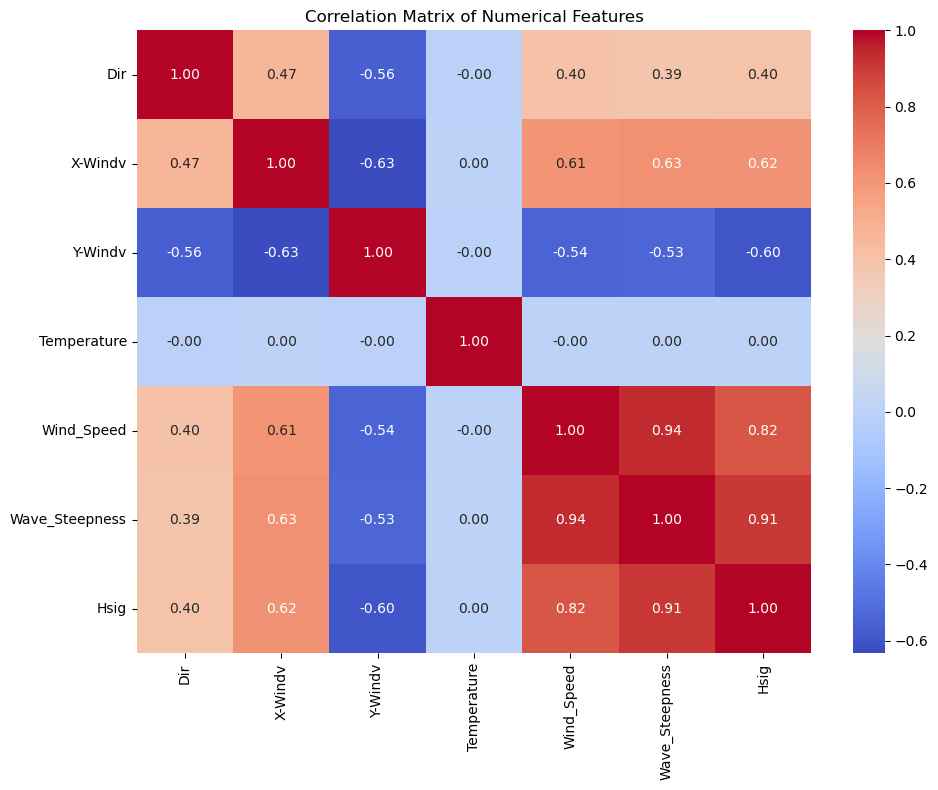

Highly correlated pairs (|correlation| > 0.8):
- Wave_Steepness and Wind_Speed: correlation = 0.94
- Hsig and Wind_Speed: correlation = 0.82
- Hsig and Wave_Steepness: correlation = 0.91


In [13]:
corr_matrix = train_eda[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Print highly correlated pairs
threshold = 0.8
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
print("Highly correlated pairs (|correlation| > 0.8):")
for pair in high_corr_pairs:
    print(f"- {pair[0]} and {pair[1]}: correlation = {pair[2]:.2f}")

Consider drop 'Wind_Speed', since it shows high collinearity with 'Wave_Steepness', where 'Wave_Steepness' is more correlated to target variable 'Hsig'.

> **Flag Issue**:
> In real world, 'Wave_Steepness' is calculated by Height/Length, which basically contains the target varible 'Hsig'.
> So Alternatively, I will drop 'Wave_Steepness' to prevent potential data leakage.

## 3.4 Categorical Features

In [14]:
cat_cols

['Season', 'Wind_Dir_Category']

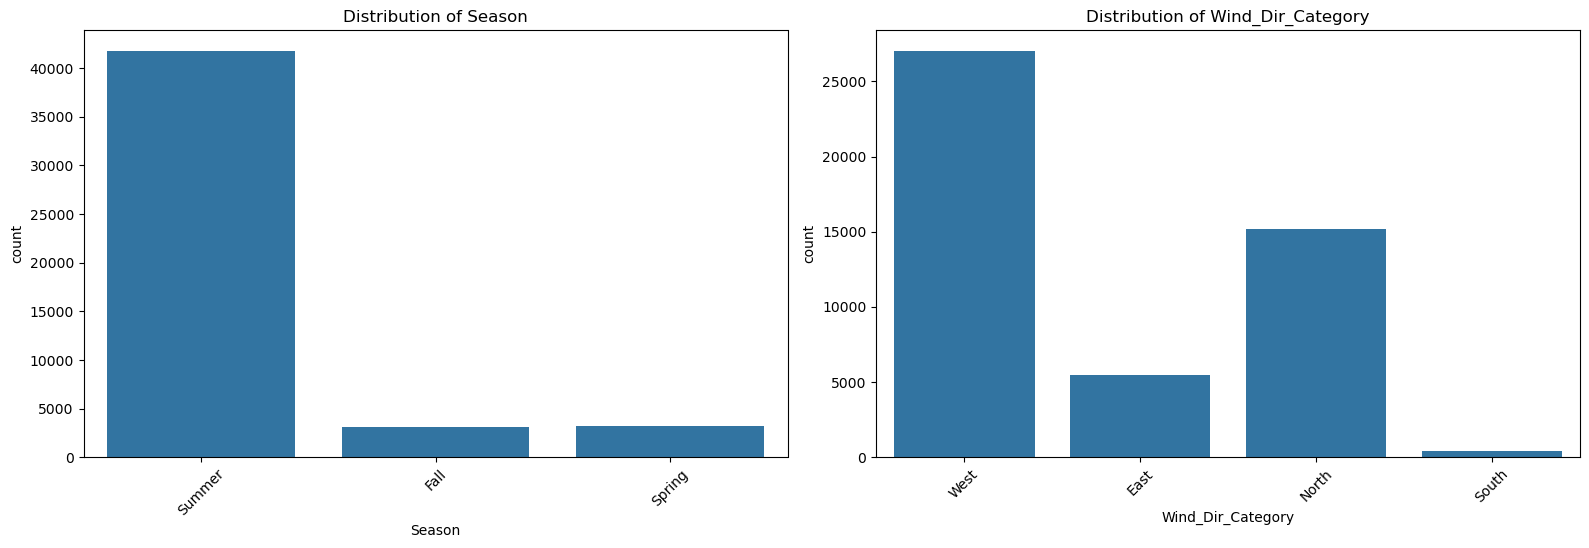

In [15]:
# Distribution of Categorical features
plt.figure(figsize=(16, 10))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=train_eda, x=col)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Extreme class imblance for 'Season', where Summer take the dominant place.
- 'South' in 'Wind_Dir_Category' have too little data points.

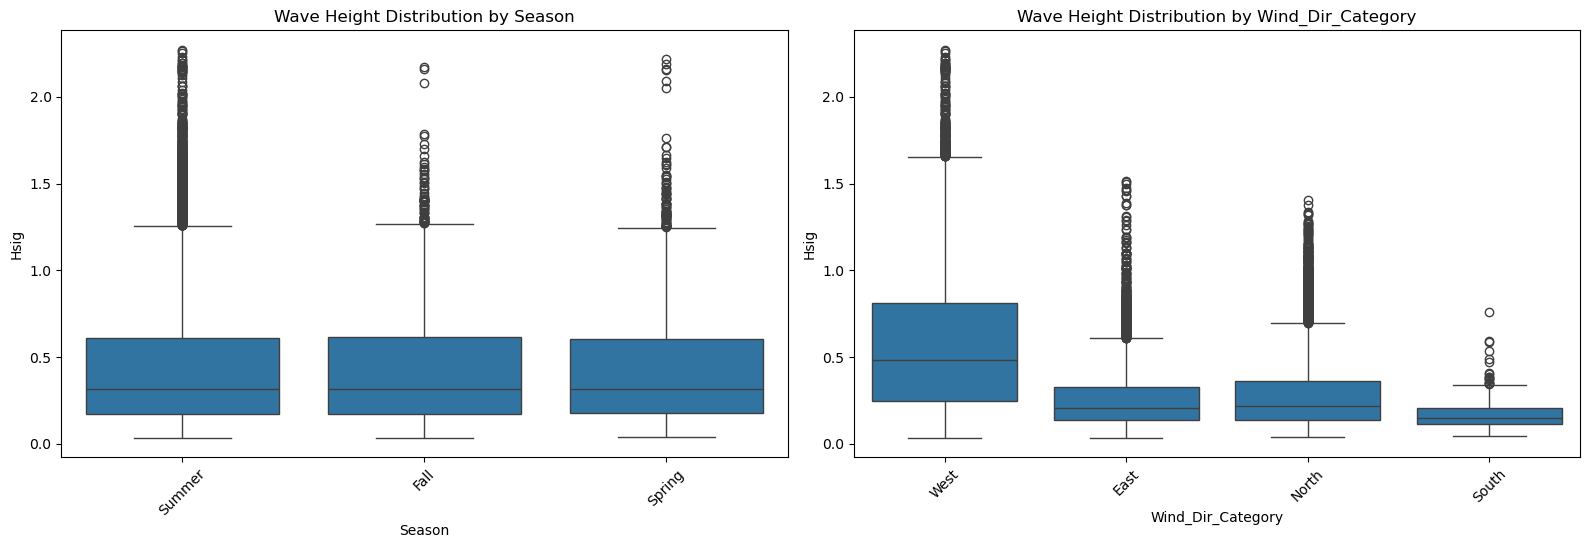

In [16]:
# Boxplot of Hsig across Seasons to evaluate how the categorical features might help predict the target variable
plt.figure(figsize=(16, 10))  # using two columns for better visibility

for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=train_eda, x=col, y='Hsig')
    plt.title(f"Wave Height Distribution by {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 'Season': three season show nearly identical pattern, the median wave hight and the spread don't change across seasons, consider dropping this feature.
- 'Wind_Dir_Category': 'West' box is taller and have highr median, could a direct driver of the 'Hsig'.

In [17]:
cols_to_drop.append('Season')
cols_to_drop

['U10', 'Xp', 'Yp', 'Depth', 'Season']

## 3.5 EDA Findings and Actions


By further investigating into the relationship between `Wind_Speed`, `Dir`, `X-Windv` and `Y-Windv`, I found out that:
*   **Physics Check:** `Wind Speed` is literally $\sqrt{X^2 + Y^2}$. `Dir` is $\arctan(Y/X)$.
*   If feed $X, Y, Speed, Dir$ into a model, we are feeding it the **exact same information twice**.

Therefore, I will remove X/Y vectors because they are mathematically redundant with Speed/Direction, which reduces noise and computational cost.

Similarly, information in `Wind_Dir_Category` is already covered by the numerical cyclic feature `Dir` after cyclic encoding it to `Dir_sin` and `Dir_cos`.

So, `Wind_Dir_Category` also will be dropped.


In [18]:
cols_to_drop += ['X-Windv', 'Y-Windv', 'Wind_Dir_Category']
cols_to_drop

['U10',
 'Xp',
 'Yp',
 'Depth',
 'Season',
 'X-Windv',
 'Y-Windv',
 'Wind_Dir_Category']

### Summary Table

| Column | Action | Reason |
|---|---|---|
| `Xp` | **Drop** | Constant value — zero variance |
| `Yp` | **Drop** | Constant value — zero variance |
| `Depth` | **Drop** | Constant value — zero variance |
| `U10` | **Drop** | 99.24% missing — not recoverable |
| `Season` | **Drop** | No discriminative power; Hsig distribution is nearly identical across all seasons |
| `Wave_Steepness` | **Drop** | Derived from wave height (H/L) → data leakage risk for predicting `Hsig` |
| `X-Windv` | **Drop** | Mathematically redundant: `Wind_Speed` = √(X² + Y²), feeding both is the same information twice |
| `Y-Windv` | **Drop** | Same reason as `X-Windv` |
| `Wind_Dir_Category` | **Drop** | Redundant with `Dir` after cyclic encoding to `Dir_sin`/`Dir_cos` |
| `Dir` | **Cyclic encoding** → `Dir_sin`, `Dir_cos` | Circular feature (0° = 360°); raw numeric encoding would introduce false discontinuity; replaces `Wind_Dir_Category` |
| `Temperature` | **Impute** missing (mean) + **KBinsDiscretizer** | 0.012% missing; no linear relationship with `Hsig` (extreme waves only at moderate 13.5–14.5°); bin into ordinal categories — then one hot encoding |
| `Wind_Speed` | **Impute** missing (median) + **Log transform** + **StandardScaler** | 0.025% missing; right-skewed; log transform reduces skew before scaling |

---

### Target Variable (`Hsig`)
- **Right-skewed** distribution — linear models may struggle.
- Prefer **tree-based ensemble models** (Random Forest, Gradient Boosting) as they handle skewed targets natively.

---

### Final Feature List (after drops)
`Dir_sin`, `Dir_cos`, `Temp_Low`, `Temp_Mod`, `Temp_High`, `Wind_Speed`


# 4. Define Data Preprocessing Pipeline

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer

cols_cyclic = ['Dir']
cols_temp   = ['Temperature']
cols_wind   = ['Wind_Speed']

def sin_cos_transform(X):
    radians = np.deg2rad(X)
    return np.concatenate([np.sin(radians), np.cos(radians)], axis=1)

def dir_feature_names(self, names):
    return ['Dir_sin', 'Dir_cos']

# 1. Dir: impute → sin/cos cyclic encoding
cyclic_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('sincos', FunctionTransformer(sin_cos_transform, validate=True,
                                   feature_names_out=dir_feature_names)),
])

# 2. Temperature: impute (mean) → bin into 3 ordinal categories → one-hot encode
temp_pipeline = Pipeline([
    ('impute',  SimpleImputer(strategy='mean')),
    ('bin',     KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile', quantile_method='averaged_inverted_cdf')),
    ('onehot',  OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# 3. Wind_Speed: impute (median) → log1p transform → standard scale
wind_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log',    FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scale',  StandardScaler()),
])

# --- Full preprocessor ---
# verbose_feature_names_out=False removes the "cyclic__", "temp__", "wind__" prefix
preprocessor = ColumnTransformer(
    transformers=[
        ('cyclic', cyclic_pipeline, cols_cyclic),
        ('temp',   temp_pipeline,   cols_temp),
        ('wind',   wind_pipeline,   cols_wind),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

preprocessor.set_output(transform='pandas')
X_train_processed = preprocessor.fit_transform(X_train)

print("Processed feature columns:", X_train_processed.columns.tolist())
print("Shape:", X_train_processed.shape)
X_train_processed.head()


Processed feature columns: ['Dir_sin', 'Dir_cos', 'Temperature_0.0', 'Temperature_1.0', 'Temperature_2.0', 'Wind_Speed']
Shape: (48125, 6)


,Dir_sin,Dir_cos,Temperature_0.0,Temperature_1.0,Temperature_2.0,Wind_Speed
67190,-0.194217,0.980959,0.0,0.0,1.0,1.526001
53616,-0.029614,0.999561,0.0,0.0,1.0,-0.367603
42844,-0.145168,0.989407,0.0,0.0,1.0,0.591300
41054,-0.260050,0.965595,0.0,0.0,1.0,0.904021
65293,-0.167078,0.985944,1.0,0.0,0.0,1.388717


In [20]:
# Process the test set using the same preprocessor fitted on the training data
X_test_processed = preprocessor.transform(X_test)
print("Processed feature columns:", X_test_processed.columns.tolist())

Processed feature columns: ['Dir_sin', 'Dir_cos', 'Temperature_0.0', 'Temperature_1.0', 'Temperature_2.0', 'Wind_Speed']


# 5. Baseline Model: Linear Regression

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train
baseline_model = LinearRegression()
baseline_model.fit(X_train_processed, y_train)

# Inference
y_pred = baseline_model.predict(X_test_processed)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Baseline Linear Regression Performance:")
print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Baseline Linear Regression Performance:
Mean Squared Error: 0.044
R^2 Score: 0.613


# 6. MLflow Experiment

## 6.1 Linear Regression

In [22]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import cross_validate

# Define Baseline Pipeline
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Setup MLflow experiment
mlflow.set_experiment("Maritime Wave Height Prediction")

# Run Evalution with Cross-Validation and log to MLflow
with mlflow.start_run(run_name="Baseline_Linear_Regression_CV"):
    
    # Log model parameters
    mlflow.log_param("model_type", "LinearRegression")
    mlflow.log_param("features", X_train_processed.columns.tolist())

    # Perform Cross-Validation
    cv_results = cross_validate(
        baseline_pipeline, X_train, y_train, cv=5,
        scoring=['neg_mean_squared_error', 'r2'],
        return_train_score=True
    )

    # Calculate mean CV metrics
    mean_mse = -np.mean(cv_results['test_neg_mean_squared_error'])
    mean_r2 = np.mean(cv_results['test_r2'])

    # Log Metrics to MLflow
    mlflow.log_metric("mean_r2", mean_r2)
    mlflow.log_metric("mean_mse", mean_mse)

    # Print the experiment results
    print("\nBaseline Linear Regression CV Performance:")
    print(f"Mean MSE: {mean_mse:.3f}")
    print(f"Mean R^2: {mean_r2:.3f}")

    # Fit the model on the entire training set
    # baseline_pipeline.fit(X_train, y_train)

    # Save the model to MLflow
    # mlflow.sklearn.log_model(baseline_pipeline, "baseline_model")

2026/02/28 14:37:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/28 14:37:22 INFO mlflow.store.db.utils: Updating database tables
2026/02/28 14:37:22 INFO mlflow.tracking.fluent: Experiment with name 'Maritime Wave Height Prediction' does not exist. Creating a new experiment.



Baseline Linear Regression CV Performance:
Mean MSE: 0.045
Mean R^2: 0.608


## 6.2 Random Forest

In [23]:
# Define max_iterations for RandomizedSearchCV
MAX_ITERATIONS = 20

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=RANDOM_SEED))
])

# Define hyperparameter search space for RandomizedSearchCV
rf_param_grid = {
    'model__n_estimators': [50, 100, 300, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__max_features': [1.0, 'sqrt']
}

# Setup RandomizedSearchCV with multi-metric scoring
rf_search = RandomizedSearchCV(
    rf_pipeline, rf_param_grid,
    n_iter=MAX_ITERATIONS, cv=5,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',  # select best model by MSE
    random_state=RANDOM_SEED, n_jobs=-1
)

# Setup MLflow experiment
mlflow.set_experiment("Maritime Wave Height Prediction")

# Run RandomizedSearchCV and log to MLflow
with mlflow.start_run(run_name="Random_Forest_RandomizedSearchCV"):

    print("Training Random Forest with RandomizedSearchCV...")
    rf_search.fit(X_train, y_train)

    # Extract R² for the best parameter combination (no extra CV pass needed)
    best_idx = rf_search.best_index_
    mean_cv_r2 = rf_search.cv_results_['mean_test_r2'][best_idx]

    # Log model parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("features", X_train_processed.columns.tolist())
    mlflow.log_params(rf_search.best_params_)

    # Log metrics of the best model
    mlflow.log_metric("best_cv_mse", -rf_search.best_score_)
    mlflow.log_metric("mean_cv_r2", mean_cv_r2)

    # Print the best hyperparameters and CV performance
    print("\nBest Hyperparameters for Random Forest:")
    print(rf_search.best_params_)
    print(f"RF Best CV MSE: {-rf_search.best_score_:.3f}")
    print(f"RF Mean CV R²:  {mean_cv_r2:.3f}")


Training Random Forest with RandomizedSearchCV...


/opt/homebrew/Caskroom/miniconda/base/envs/dsml/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Hyperparameters for Random Forest:
{'model__n_estimators': 500, 'model__min_samples_split': 5, 'model__max_features': 1.0, 'model__max_depth': 10}
RF Best CV MSE: 0.022
RF Mean CV R²:  0.808


## 6.3 XGBoost

In [25]:
from xgboost import XGBRegressor

# Define XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=RANDOM_SEED, objective='reg:squarederror'))
])

# Define hyperparameter search space for RandomizedSearchCV
xgb_param_grid = {
    'model__n_estimators':[100, 300, 500, 800],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 9],
    'model__subsample':[0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree':[0.7, 0.8, 0.9, 1.0]
}

# Setup RandomizedSearchCV with multi-metric scoring
xgb_search = RandomizedSearchCV(
    xgb_pipeline, xgb_param_grid,
    n_iter=MAX_ITERATIONS, cv=5,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',  # select best model by MSE
    random_state=RANDOM_SEED, n_jobs=-1
)

# Setup MLflow experiment
mlflow.set_experiment("Maritime Wave Height Prediction")

# Run RandomizedSearchCV and log to MLflow
with mlflow.start_run(run_name="XGBoost_RandomizedSearchCV"):

    print("Training XGBoost with RandomizedSearchCV...")
    xgb_search.fit(X_train, y_train)

    # Extract R² for the best parameter combination
    best_idx = xgb_search.best_index_
    mean_cv_r2 = xgb_search.cv_results_['mean_test_r2'][best_idx]

    # Log model parameters
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("features", X_train_processed.columns.tolist())
    mlflow.log_params(xgb_search.best_params_)

    # Log metrics of the best model
    mlflow.log_metric("best_cv_mse", -xgb_search.best_score_)
    mlflow.log_metric("mean_cv_r2", mean_cv_r2)

    # Print the best hyperparameters and CV performance
    print("\nBest Hyperparameters for XGBoost:")
    print(xgb_search.best_params_)
    print(f"XGBoost Best CV MSE: {-xgb_search.best_score_:.3f}")
    print(f"XGBoost Mean CV R²:  {mean_cv_r2:.3f}")


Training XGBoost with RandomizedSearchCV...

Best Hyperparameters for XGBoost:
{'model__subsample': 1.0, 'model__n_estimators': 800, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.7}
XGBoost Best CV MSE: 0.022
XGBoost Mean CV R²:  0.808


## 6.4 LightGBM

In [26]:
from lightgbm import LGBMRegressor

# Define LightGBM Pipeline
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=RANDOM_SEED, verbose=-1))
])

# Define hyperparameter search space for RandomizedSearchCV
lgbm_param_grid = {
    'model__n_estimators': [100, 300, 500, 800],
    'model__learning_rate':[0.01, 0.05, 0.1, 0.2],
    'model__num_leaves':[31, 63, 127],
    'model__subsample':[0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree':[0.7, 0.8, 0.9, 1.0]
}

# Setup RandomizedSearchCV with multi-metric scoring
lgbm_search = RandomizedSearchCV(
    lgbm_pipeline, lgbm_param_grid,
    n_iter=MAX_ITERATIONS, cv=5,
    scoring={'mse': 'neg_mean_squared_error', 'r2': 'r2'},
    refit='mse',  # select best model by MSE
    random_state=RANDOM_SEED, n_jobs=-1
)

# Setup MLflow experiment
mlflow.set_experiment("Maritime Wave Height Prediction")

# Run RandomizedSearchCV and log to MLflow
with mlflow.start_run(run_name="LightGBM_RandomizedSearchCV"):

    print("Training LightGBM with RandomizedSearchCV...")
    lgbm_search.fit(X_train, y_train)

    # Extract R² for the best parameter combination
    best_idx = lgbm_search.best_index_
    mean_cv_r2 = lgbm_search.cv_results_['mean_test_r2'][best_idx]

    # Log model parameters
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("features", X_train_processed.columns.tolist())
    mlflow.log_params(lgbm_search.best_params_)

    # Log metrics of the best model
    mlflow.log_metric("best_cv_mse", -lgbm_search.best_score_)
    mlflow.log_metric("mean_cv_r2", mean_cv_r2)

    # Print the best hyperparameters and CV performance
    print("\nBest Hyperparameters for LightGBM:")
    print(lgbm_search.best_params_)
    print(f"LightGBM Best CV MSE: {-lgbm_search.best_score_:.3f}")
    print(f"LightGBM Mean CV R²:  {mean_cv_r2:.3f}")


Training LightGBM with RandomizedSearchCV...

Best Hyperparameters for LightGBM:
{'model__subsample': 0.7, 'model__num_leaves': 31, 'model__n_estimators': 100, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}
LightGBM Best CV MSE: 0.022
LightGBM Mean CV R²:  0.808


Surprisingly, we found out that the Random Forest model, XGBoost, and LightGBM converged on an $R^2 = 0.808$ and $MSE = 0.022$. This implies we have hit the "signal ceiling" of the current dataset using this data preprocessing pipeline, with `Wind_Speed` serving as the dominant predictor.

To further select the best model, **I will benchmark their memory usage and inference speed**.

# 7. Benchmarking

In [27]:
import time
import io
import cloudpickle

# Extract the best pipelines
models_to_test = {
    "Random Forest": rf_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_,
    "LightGBM": lgbm_search.best_estimator_
}

N_TRIALS = 20
benchmark_results = {}

for name, model in models_to_test.items():

    # -- Inference Speed --
    # Warm-up pass to avoid cold-start bias
    _ = model.predict(X_test)

    times = []
    for _ in range(N_TRIALS):
        t0 = time.perf_counter()
        model.predict(X_test)
        times.append(time.perf_counter() - t0)

    mean_ms = np.mean(times) * 1000
    std_ms  = np.std(times)  * 1000

    # -- Memory Usage (serialized model size) --
    # cloudpickle serializes by bytecode, avoiding identity mismatch for object reference
    buf = io.BytesIO()
    cloudpickle.dump(model, buf)
    size_mb = buf.tell() / (1024 ** 2)

    benchmark_results[name] = {
        'mean_inference_ms': round(mean_ms, 2),
        'std_inference_ms':  round(std_ms,  2),
        'model_size_mb':     round(size_mb, 2),
    }

    print(f"{name}:")
    print(f"  Inference:  {mean_ms:.1f} ± {std_ms:.1f} ms  ({N_TRIALS} trials, {len(X_test):,} samples)")
    print(f"  Model size: {size_mb:.2f} MB")
    print()


Random Forest:
  Inference:  564.9 ± 1.6 ms  (20 trials, 20,626 samples)
  Model size: 52.25 MB

XGBoost:
  Inference:  35.9 ± 2.5 ms  (20 trials, 20,626 samples)
  Model size: 2.09 MB

LightGBM:
  Inference:  21.6 ± 1.0 ms  (20 trials, 20,626 samples)
  Model size: 0.30 MB



,mean_inference_ms,std_inference_ms,model_size_mb
Model,,,
Random Forest,564.87,1.59,52.25
XGBoost,35.92,2.47,2.09
LightGBM,21.59,1.02,0.30


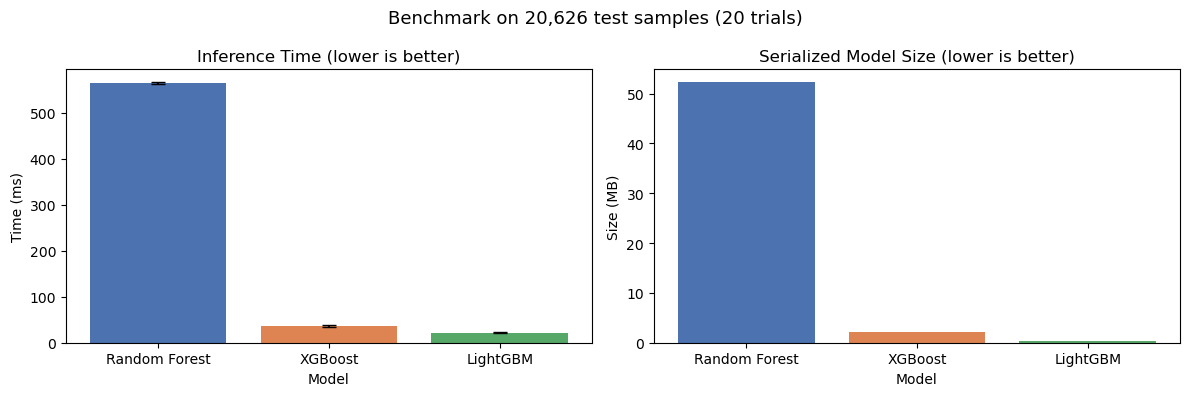

In [28]:
# Summary table
benchmark_df = pd.DataFrame(benchmark_results).T
benchmark_df.index.name = 'Model'
display(benchmark_df)

# Create a bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['#4C72B0', '#DD8452', '#55A868']

# Inference speed
axes[0].bar(benchmark_df.index, benchmark_df['mean_inference_ms'],
            yerr=benchmark_df['std_inference_ms'], capsize=5, color=colors)
axes[0].set_title('Inference Time (lower is better)')
axes[0].set_ylabel('Time (ms)')
axes[0].set_xlabel('Model')

# Model size
axes[1].bar(benchmark_df.index, benchmark_df['model_size_mb'], color=colors)
axes[1].set_title('Serialized Model Size (lower is better)')
axes[1].set_ylabel('Size (MB)')
axes[1].set_xlabel('Model')

plt.suptitle(f'Benchmark on {len(X_test):,} test samples ({N_TRIALS} trials)', fontsize=13)
plt.tight_layout()
plt.show()


We see:
- LightGBM is ~24x faster at predicting than Random Forest. (It can process 20,000 requests within 22 milliseconds!)
- LightGBM uses ~180x less RAM than Random Forest (0.30 MB vs. 52.25 MB).

Thus, **LightGBM is the winner**!

# 8. Final Re-Train and Results

No need for re-train since `refit='mse'` already helped my handle that.

In [29]:
final_model = lgbm_search.best_estimator_
final_params = lgbm_search.best_params_

print("Final Model: LightGBM with parameters:")
print(final_params)

# print final mse and r2 on the test set
y_final_pred = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_final_pred)
final_r2 = r2_score(y_test, y_final_pred)
print(f"Final Model Test MSE: {final_mse:.3f}")
print(f"Final Model Test R²:  {final_r2:.3f}")


Final Model: LightGBM with parameters:
{'model__subsample': 0.7, 'model__num_leaves': 31, 'model__n_estimators': 100, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}
Final Model Test MSE: 0.022
Final Model Test R²:  0.808


# 9. Save Final Model

In [30]:
import os

MODEL_PATH = "../models/lgbm_best.pkl"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

with open(MODEL_PATH, "wb") as f:
    cloudpickle.dump(lgbm_search.best_estimator_, f)

print(f"Model saved to {MODEL_PATH}")
print(f"File size: {os.path.getsize(MODEL_PATH) / (1024 ** 2):.2f} MB")


Model saved to ../models/lgbm_best.pkl
File size: 0.30 MB
